# Exploring COVID-19 time series data from Johns Hopkins University

This notebook analyzes the data in the [CSSEGISandData/COVID-19](https://github.com/CSSEGISandData/COVID-19) github repo. This assumes you have cloned the repo at the local path `~/github/CSSEGISandData/COVID-19`.

In [27]:
import os
import pandas as pd
import torch
import datetime
import matplotlib.pyplot as plt

In [2]:
dirname = os.path.expanduser("~/github/CSSEGISandData/COVID-19/"
                             "csse_covid_19_data/csse_covid_19_time_series")
def read_csv(basename):
    return pd.read_csv(os.path.join(dirname, basename), header=0)
us_cases_df = read_csv("time_series_covid19_confirmed_US.csv")
us_deaths_df = read_csv("time_series_covid19_deaths_US.csv")
global_cases_df = read_csv("time_series_covid19_confirmed_global.csv")
global_deaths_df = read_csv("time_series_covid19_deaths_global.csv")

In [3]:
us_cases_df

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,11/13/21,11/14/21,11/15/21,11/16/21,11/17/21,11/18/21,11/19/21,11/20/21,11/21/21,11/22/21
0,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,...,10401,10403,10407,10419,10423,10439,10457,10468,10471,10477
1,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,...,37855,37865,37875,37891,37914,37940,37959,37981,37986,38000
2,84001005,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,-85.387129,...,3648,3648,3648,3653,3655,3659,3660,3683,3687,3688
3,84001007,US,USA,840,1007.0,Bibb,Alabama,US,32.996421,-87.125115,...,4317,4317,4317,4323,4325,4328,4333,4337,4337,4337
4,84001009,US,USA,840,1009.0,Blount,Alabama,US,33.982109,-86.567906,...,10530,10534,10536,10548,10568,10598,10621,10626,10636,10640
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3337,84056039,US,USA,840,56039.0,Teton,Wyoming,US,43.935225,-110.589080,...,5301,5301,5309,5323,5336,5344,5350,5350,5350,5362
3338,84056041,US,USA,840,56041.0,Uinta,Wyoming,US,41.287818,-110.547578,...,3950,3950,3965,3975,3985,3996,4005,4005,4005,4006
3339,84090056,US,USA,840,90056.0,Unassigned,Wyoming,US,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
3340,84056043,US,USA,840,56043.0,Washakie,Wyoming,US,43.904516,-107.680187,...,1815,1815,1819,1820,1822,1821,1823,1823,1823,1831


In [4]:
us_deaths_df

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,11/13/21,11/14/21,11/15/21,11/16/21,11/17/21,11/18/21,11/19/21,11/20/21,11/21/21,11/22/21
0,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,...,154,154,154,154,155,156,156,156,156,156
1,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,...,581,581,581,583,586,586,586,588,588,588
2,84001005,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,-85.387129,...,79,79,79,79,79,79,79,80,80,80
3,84001007,US,USA,840,1007.0,Bibb,Alabama,US,32.996421,-87.125115,...,92,92,92,92,92,93,93,93,93,93
4,84001009,US,USA,840,1009.0,Blount,Alabama,US,33.982109,-86.567906,...,188,188,188,188,188,190,190,190,190,190
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3337,84056039,US,USA,840,56039.0,Teton,Wyoming,US,43.935225,-110.589080,...,14,14,14,14,14,14,14,14,14,14
3338,84056041,US,USA,840,56041.0,Uinta,Wyoming,US,41.287818,-110.547578,...,29,29,29,30,30,30,30,30,30,30
3339,84090056,US,USA,840,90056.0,Unassigned,Wyoming,US,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
3340,84056043,US,USA,840,56043.0,Washakie,Wyoming,US,43.904516,-107.680187,...,35,35,35,35,35,35,35,35,35,35


In [5]:
global_cases_df

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,11/13/21,11/14/21,11/15/21,11/16/21,11/17/21,11/18/21,11/19/21,11/20/21,11/21/21,11/22/21
0,NaN,Afghanistan,33.939110,67.709953,0,0,0,0,0,0,...,156510,156552,156610,156649,156739,156739,156812,156864,156896,156911
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,...,192600,193075,193269,193856,194472,195021,195523,195988,195988,196611
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,...,207873,207970,208104,208245,208380,208532,208695,208839,208952,209111
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,...,15819,15819,15907,15929,15972,16035,16086,16086,16086,16299
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,...,64899,64913,64913,64940,64968,64985,64997,65011,65024,65033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,NaN,Vietnam,14.058324,108.277199,0,2,2,2,2,2,...,1018346,1026522,1035138,1045397,1055246,1065469,1075094,1084625,1094514,1104835
276,NaN,West Bank and Gaza,31.952200,35.233200,0,0,0,0,0,0,...,456632,456632,457154,457390,457477,457729,457950,457950,457950,458448
277,NaN,Yemen,15.552727,48.516388,0,0,0,0,0,0,...,9918,9918,9936,9936,9947,9950,9954,9955,9955,9961
278,NaN,Zambia,-13.133897,27.849332,0,0,0,0,0,0,...,209971,209983,209996,210008,210020,210036,210043,210057,210070,210073


In [6]:
global_deaths_df

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,11/13/21,11/14/21,11/15/21,11/16/21,11/17/21,11/18/21,11/19/21,11/20/21,11/21/21,11/22/21
0,NaN,Afghanistan,33.939110,67.709953,0,0,0,0,0,0,...,7292,7293,7294,7295,7297,7297,7361,7363,7365,7365
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,...,2986,2990,2997,3004,3014,3022,3029,3035,3035,3049
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,...,5977,5984,5991,5997,6005,6009,6015,6017,6021,6026
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,...,130,130,130,130,130,130,130,130,130,130
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,...,1727,1727,1727,1729,1729,1729,1729,1730,1730,1730
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,NaN,Vietnam,14.058324,108.277199,0,0,0,0,0,0,...,23018,23082,23183,23270,23337,23476,23578,23685,23761,23951
276,NaN,West Bank and Gaza,31.952200,35.233200,0,0,0,0,0,0,...,4743,4743,4754,4761,4764,4767,4770,4770,4770,4779
277,NaN,Yemen,15.552727,48.516388,0,0,0,0,0,0,...,1923,1923,1926,1926,1929,1934,1935,1938,1938,1939
278,NaN,Zambia,-13.133897,27.849332,0,0,0,0,0,0,...,3664,3666,3666,3666,3666,3666,3667,3667,3667,3667


In [7]:
print(us_cases_df.columns[6:])
print(us_deaths_df.columns[6:])
print(global_cases_df.columns)
print(global_deaths_df.columns)

Index(['Province_State', 'Country_Region', 'Lat', 'Long_', 'Combined_Key',
       '1/22/20', '1/23/20', '1/24/20', '1/25/20', '1/26/20',
       ...
       '11/13/21', '11/14/21', '11/15/21', '11/16/21', '11/17/21', '11/18/21',
       '11/19/21', '11/20/21', '11/21/21', '11/22/21'],
      dtype='object', length=676)
Index(['Province_State', 'Country_Region', 'Lat', 'Long_', 'Combined_Key',
       'Population', '1/22/20', '1/23/20', '1/24/20', '1/25/20',
       ...
       '11/13/21', '11/14/21', '11/15/21', '11/16/21', '11/17/21', '11/18/21',
       '11/19/21', '11/20/21', '11/21/21', '11/22/21'],
      dtype='object', length=677)
Index(['Province/State', 'Country/Region', 'Lat', 'Long', '1/22/20', '1/23/20',
       '1/24/20', '1/25/20', '1/26/20', '1/27/20',
       ...
       '11/13/21', '11/14/21', '11/15/21', '11/16/21', '11/17/21', '11/18/21',
       '11/19/21', '11/20/21', '11/21/21', '11/22/21'],
      dtype='object', length=675)
Index(['Province/State', 'Country/Region', 'Lat', 'L

In [8]:
def to_torch(df, first_column):
    df = df[df.columns[first_column:]]
    return torch.from_numpy(df.to_numpy()).float()

case_data = torch.cat([to_torch(us_cases_df, first_column=11),
                       to_torch(global_cases_df, first_column=4)])
print(case_data.shape)
case_data

torch.Size([3622, 671])


tensor([[     0.,      0.,      0.,  ...,  10468.,  10471.,  10477.],
        [     0.,      0.,      0.,  ...,  37981.,  37986.,  38000.],
        [     0.,      0.,      0.,  ...,   3683.,   3687.,   3688.],
        ...,
        [     0.,      0.,      0.,  ...,   9955.,   9955.,   9961.],
        [     0.,      0.,      0.,  ..., 210057., 210070., 210073.],
        [     0.,      0.,      0.,  ..., 133615., 133647., 133674.]])

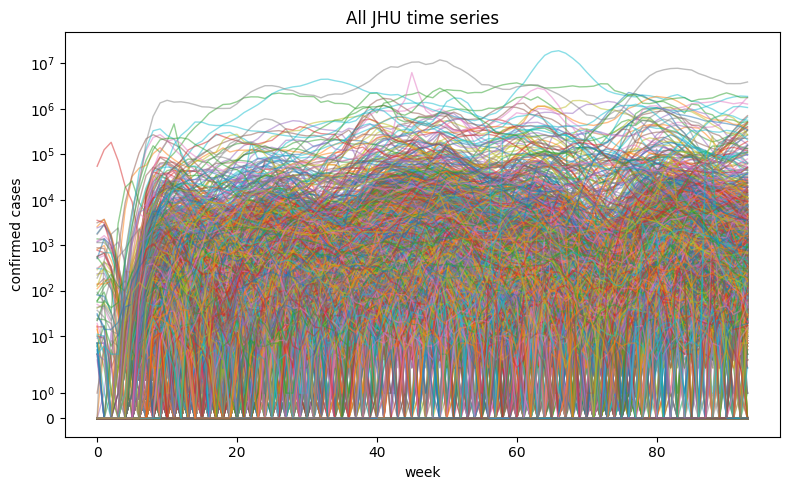

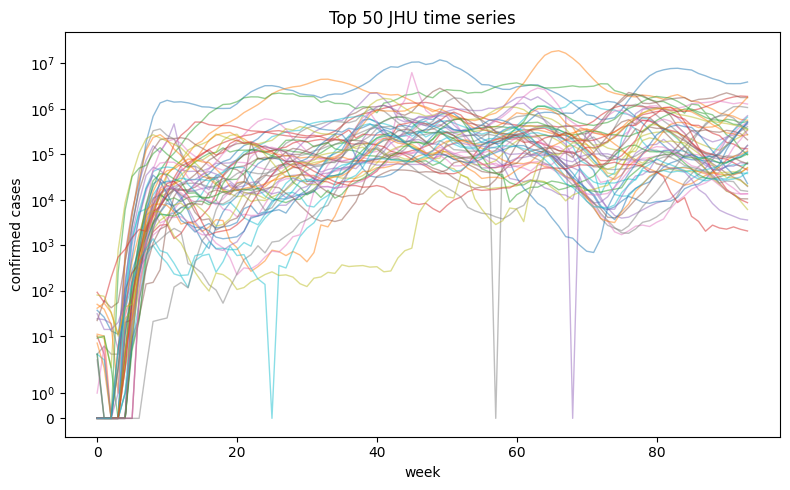

In [39]:
round_size = case_data.size(-1) // 7 * 7
cumsum = case_data[:, :round_size].reshape(-1, round_size // 7, 7).sum(-1)
cases = (cumsum[:, 1:] - cumsum[:, :-1]).clamp_(min=0)
topk = cumsum.sum(-1).sort(descending=True).indices[:50]
plt.figure(figsize=(8, 5))
plt.plot(cases.T, alpha=0.5, lw=1)
plt.yscale("symlog")
plt.xlabel("week")
plt.ylabel("confirmed cases")
plt.title("All JHU time series")
plt.tight_layout()

plt.figure(figsize=(8, 5))
plt.plot(cases[topk].T, alpha=0.5, lw=1)
plt.yscale("symlog")
plt.xlabel("week")
plt.ylabel("confirmed cases")
plt.title("Top 50 JHU time series")
plt.tight_layout()

In [9]:
death_data = torch.cat([to_torch(us_deaths_df, first_column=12),
                        to_torch(global_deaths_df, first_column=4)])
print(death_data.shape)
death_data

torch.Size([3622, 671])


tensor([[   0.,    0.,    0.,  ...,  156.,  156.,  156.],
        [   0.,    0.,    0.,  ...,  588.,  588.,  588.],
        [   0.,    0.,    0.,  ...,   80.,   80.,   80.],
        ...,
        [   0.,    0.,    0.,  ..., 1938., 1938., 1939.],
        [   0.,    0.,    0.,  ..., 3667., 3667., 3667.],
        [   0.,    0.,    0.,  ..., 4699., 4699., 4699.]])

In [10]:
import pickle
from collections import Counter
gisaid_locations = Counter(pickle.load(open("results/gisaid.columns.pkl", "rb"))["location"])
print(len(gisaid_locations))

5820


In [11]:
for name, count in gisaid_locations.most_common(30):
    print(f"{count}\t{name}")

1005128	Europe / United Kingdom / England
265034	North America / USA / California
130690	North America / USA / Texas
124999	Europe / United Kingdom / Scotland
106017	Europe / United Kingdom / Wales
105351	North America / USA / Florida
97757	Europe / Denmark / Hovedstaden
89390	North America / USA / New York
72420	North America / USA / Colorado
69780	North America / USA / Minnesota
68906	North America / Canada / British Columbia
68412	Europe / Germany / North Rhine Westphalia
66069	Europe / Turkey
65120	North America / USA / Massachusetts
62494	North America / USA / Washington
45741	North America / USA / Michigan
44485	North America / USA / Arizona
42599	North America / USA / North Carolina
41728	North America / USA / Illinois
40407	North America / Canada / Ontario
39108	North America / USA / Utah
38363	South America / Brazil / Sao Paulo
36643	Europe / Denmark / Midtjylland
35682	Europe / Germany / Baden Wurttemberg
33914	North America / USA / Maryland
33697	North America / USA / Georgi

In [12]:
gisaid_locations = {tuple(part.strip() for part in key.lower().split("/")[1:])
                    for key in gisaid_locations}
gisaid_locations = {loc for loc in gisaid_locations if len(loc) >= 1}
print(len(gisaid_locations))
print(sorted(gisaid_locations)[:20])

5815
[('afghanistan',), ('albania',), ('albania', 'moerfelden walldorf'), ('algeria', 'adrar'), ('algeria', 'alger'), ('algeria', 'algiers'), ('algeria', 'batna'), ('algeria', 'biskra'), ('algeria', 'blida'), ('algeria', 'bordj bou arreridj'), ('algeria', 'boufarik'), ('algeria', 'bouira'), ('algeria', 'djelfa'), ('algeria', 'eddis'), ('algeria', 'el oued'), ('algeria', 'laghouat'), ('algeria', 'medea'), ('algeria', 'oran'), ('algeria', 'ouargla'), ('algeria', 'setif')]


In [13]:
jhu_locations = set()
for i, row in us_cases_df[["Country_Region", "Province_State", "Admin2"]].iterrows():
    a, b, c = row
    if isinstance(c, str):
        jhu_locations.add((a.lower(), b.lower(), c.lower()))
    else:
        jhu_locations.add((a.lower(), b.lower()))
for i, row in global_cases_df[["Country/Region", "Province/State"]].iterrows():
    a, b = row
    if isinstance(b, str):
        jhu_locations.add((a.lower(), b.lower()))
    else:
        jhu_locations.add((a.lower(),))
assert len(jhu_locations) == len(us_cases_df) + len(global_cases_df)
print(len(jhu_locations))
print(sorted(jhu_locations)[:20])

3622
[('afghanistan',), ('albania',), ('algeria',), ('andorra',), ('angola',), ('antigua and barbuda',), ('argentina',), ('armenia',), ('australia', 'australian capital territory'), ('australia', 'new south wales'), ('australia', 'northern territory'), ('australia', 'queensland'), ('australia', 'south australia'), ('australia', 'tasmania'), ('australia', 'victoria'), ('australia', 'western australia'), ('austria',), ('azerbaijan',), ('bahamas',), ('bahrain',)]


In [14]:
print(len(gisaid_locations & jhu_locations))
print(len(gisaid_locations - jhu_locations))
print(len(jhu_locations - gisaid_locations))

175
5640
3447


In [15]:
gc = {loc[0] for loc in gisaid_locations}
jc = {loc[0] for loc in jhu_locations}
print(gc - jc)

{'south korea', 'martinique', 'the bahamas', 'cote d ivoire', 'anguilla', 'gibraltar', 'democratic republic of the congo', 'wallis and futuna islands', 'saint martin', 'sint eustatius', 'canary islands', 'taiwan', 'reunion', 'northern mariana islands', 'hong kong', 'bermuda', 'guam', 'puerto rico', 'sint maarten', 'faroe islands', 'bonaire', 'guinea bissau', 'czech republic', 'turks and caicos islands', 'french guiana', 'guadeloupe', 'republic of the congo', 'curacao', 'cayman islands', 'timor leste', 'myanmar', 'saint barthelemy', 'palestine', 'usa', 'french polynesia', 'british virgin islands', 'montserrat', 'slovak republic', 'crimea', 'mayotte', 'aruba'}


In [16]:
{row for row in jhu_locations if any("serrat" in col for col in row)}

{('united kingdom', 'montserrat')}

In [17]:
from pyrocov.geo import GISAID_TO_JHU

for country in gc - jc:
    c = GISAID_TO_JHU[country]
    assert c is None or isinstance(c, tuple), c

In [18]:
with open("results/mutrans.data.single.10000.50.best.None.pt", "rb") as f:
    locations = list(torch.load(f)["location_id"])
locations = sorted(set(locations))

FileNotFoundError: [Errno 2] No such file or directory: 'results/mutrans.data.single.10000.50.best.None.pt'

In [19]:
from pyrocov.geo import gisaid_to_jhu_location
gisaid_to_jhu_location(locations, us_cases_df, global_cases_df)

NameError: name 'locations' is not defined

In [20]:
query = "timor"
for parts in jhu_locations:
    if any(query in part for part in parts):
        print(parts)

('us', 'maryland', 'baltimore city')
('us', 'maryland', 'baltimore')
('timor-leste',)


## Joining with population data from UN

`WPP2019_TotalPopulationBySex.csv` was downloaded from https://population.un.org/wpp/Download/Standard/CSV/

In [21]:
df = pd.read_csv("data/WPP2019_TotalPopulationBySex.csv", header=0)
df.columns

FileNotFoundError: [Errno 2] File data/WPP2019_TotalPopulationBySex.csv does not exist: 'data/WPP2019_TotalPopulationBySex.csv'

In [22]:
df = df[df["Time"] == 2020]
df = df[df["Variant"] == "High"]

NameError: name 'df' is not defined

In [23]:
uc = {name.lower() for name in df["Location"].to_list()}
jc - uc

NameError: name 'df' is not defined

In [24]:
{row for row in uc if "myanmar" in row}

NameError: name 'uc' is not defined

In [25]:
from pyrocov.geo import JHU_TO_UN

In [26]:
for c in jc:
    if c not in uc:
        c2 = JHU_TO_UN[c]
        if c2 is not None:
            assert c2 in uc, (c, c2)

NameError: name 'uc' is not defined